In [11]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from math import log10
from math import pi
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from astropy.table import Table
from astropy.cosmology import Planck13
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from scipy import misc
from scipy.ndimage import zoom
from scipy.ndimage.interpolation import rotate
import glob
from astropy.io import fits
from astropy.table import Table
from math import log10
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.pyplot import imread
from scipy.ndimage import zoom
from scipy.ndimage.interpolation import rotate
import glob

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten

from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import rmsprop

import random
import pdb
import time

from sklearn.utils import shuffle

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras.models import model_from_json
from keras.models import model_from_yaml
from keras.optimizers import SGD

%matplotlib inline

# Train a simple CNN for galaxy morphology

The goal of this tutorial is to perform the same classification performed in the first tuorial with catalog data but using CNNs and images as inputs.

The first cells until the cell called Read are just functions. They do not output anything. You only need to compile them.

# Function to read images

In [13]:
# to cut stamps -- ignore
def extract_thumb(im,x,y,size):
    if size %2==0:
        size = size+1
    up_x=int(x-size/2)
    dow_x=int(x+size/2)
    up_y=int(y-size/2)
    dow_y=int(y+size/2)
    res=im[up_x:dow_x,up_y:dow_y]        
    return res 

# this function only reads jpeg images and saves them to a numpy array. images are rebnned to a 69*68 pixel size to 
# speed computation in the CNN part.
# not very "clean" -- sorry
def read_data(pathsave,maxim):
    
    # image size that will go into the network (this is only for the deep learning part, not the RF)
    size_im=69
    size_crop=207
  

    data=fits.getdata('Nair_Abraham_cat.fit',1)
    idcat=data['dr7objid']
    ttype=data['TType']
    
    #define the morphologies we want to retrieve
    m=ttype*0-1
    # this should select elliptical galaxies(visually classified)
    m[np.where((ttype>=-5) & (ttype<=0))]=0
    # this should select spiral galaxies (visually classified)
    m[np.where((ttype>0) & (ttype<=10))]=1
      
    D=np.zeros([maxim,size_im,size_im,3])  #input tensor - images dimensions + color channels
    Y=np.zeros(maxim) #label vector
    idvec=np.zeros([maxim], dtype=np.long)
    
    iteri=-1;
    numim=0;
    numim_init=numim
    nplace=0  #location 1st galaxy to be read 
    catalog=Table(data)

    while iteri<maxim-1:
        if iteri>=-1:
            numgal=idcat[numim]
            namegal=str(numgal)+"_GZOO_.jpg"        
            scidata = imread('cutouts_jpeg_all/'+namegal)
            f=numim
            
            print('reading: '+namegal)
            
        if iteri<-1:
            print("Galaxy number %d is missing" % (numim))
            print(namegal)
            numim += 1
            continue
        
        lx,ly, lz=scidata.shape
        #wrong shape - ignore image
        if lx < 256 or ly<256 or m[f]<0:
            numim += 1
            continue

        if lx<size_im:
            numim += 1
            continue

        
        scidata = extract_thumb(scidata,int(lx/2.0),int(ly/2.0),size_crop) # take only a cutout of 207*207 pixels
        scidata=zoom(scidata, [1/3.,1./3,1], order=3)  #keep 1/3 pixels to speed up
        
        
        iteri=iteri+1
        
        
        D[iteri,:,:,:]=scidata  #add image to the input tensor

        Y[iteri]=m[numim] #update the label
        
        idvec[iteri]=idcat[numim] 

        if (m[numim]==0 and iteri%100 ==0):
            print("Saving example")
            misc.imsave(pathsave+"example_stamps/"+namegal,scidata)
            
         
        numim=numim+1

        
        Y = Y.squeeze()

    # this is to avoid reading all images at every training
    print("Saving image and target vector")
    np.save(pathsave+"image_vector_Sab_"+str(maxim)+".npy",D) 
    np.save(pathsave+"target_vector_Sab_"+str(maxim)+".npy",Y)
    np.save(pathsave+"ID_vector_Sab_"+str(maxim)+".npy",idvec) 

    return D,Y

# D contains the images
# Y the labels to be learned (morphology, i.e. y=0-->elliptical, y=1-->spiral)


# Function for model definition

In [14]:
def CNN_Nair(img_channels, img_rows, img_cols):
    
    # some hyperparamters you can chage
    dropoutpar=0.5
    depth=16 #32   
    nb_dense = 64
    
    # SGD parameters [when using SGD optimizer]
    #lr=0.001   #0.001
    #decay=0
    #momentum=0.9   #0.9
    #nesterov=True

    model=Sequential()
    model.add(Convolution2D(32, 6,6, border_mode='same',input_shape=(img_rows, img_cols,img_channels)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Convolution2D(64, 5, 5, border_mode='same'))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Convolution2D(64, 5, 5, border_mode='same'))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Convolution2D(128, 2, 2, border_mode='same'))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Convolution2D(128, 3, 3, border_mode='same'))
    model.add(Activation('relu'))
    
    model.add(Dropout(0.25))
    

    model.add(Flatten())
    model.add(Dense(nb_dense, activation='relu'))
    model.add(Dropout(dropoutpar)) 
    model.add(Dense(1, init='uniform', activation='sigmoid'))
    print("Compilation...")
    
    # you can change here to SGD optimizer
    #sgd = SGD(lr=lr, decay=decay, momentum=momentum, nesterov=True) #uncomment to use sgd
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    print("... done!")
    print("Model Summary")
    print("===================")
    model.summary()
    return model

# Function to train

In [15]:
def train_convnet_Nair(X,Y,ntrain,nval,test_name):


    # train params - hardocded for simplicity - you can change them
    batch_size = 30 
    nb_epoch = 50
    data_augmentation = True # if set to True the data will be augmented at every iteration
    
    
    ind=random.sample(range(0, ntrain+nval-1), ntrain+nval-1)
    X_train = X[ind[0:ntrain],:,:,:]   
    X_val = X[ind[ntrain:ntrain+nval],:,:,:]
    Y_train = Y[ind[0:ntrain]]
    Y_val = Y[ind[ntrain:ntrain+nval]]

   
    # input image dimensions
    img_rows, img_cols = X_train.shape[1:3]
    img_channels = 3

    
    ### Right shape for X -- ignore
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols,img_channels)
    X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols,img_channels)


    #Avoid more iterations once convergence
    patience_par=10
    earlystopping = EarlyStopping( monitor='val_loss',patience = patience_par,verbose=0,mode='auto' )
    modelcheckpoint = ModelCheckpoint(test_name+"_best.hd5",monitor='val_loss',verbose=0,save_best_only=True)


    #build model
    model=CNN_Nair(img_channels, img_rows, img_cols)




    if not data_augmentation:
        print('Not using data augmentation.')
        history = model.fit(X_train, Y_train,
                            batch_size=batch_size,
                            nb_epoch=nb_epoch,
                            validation_data=(X_val, Y_val),
                            shuffle=True,
                            verbose=verbose, callbacks=[earlystopping, modelcheckpoint])
    else:
        print('Using real-time data augmentation.')

        # this will do preprocessing and realtime data augmentation
        datagen = ImageDataGenerator(
            featurewise_center=False, 
            samplewise_center=False, 
            featurewise_std_normalization=False, 
            samplewise_std_normalization=False,
            zca_whitening=False, 
            rotation_range=45,
            width_shift_range=0.05,  
            height_shift_range=0.05, 
            horizontal_flip=True,
            vertical_flip=True,
            zoom_range=[0.75,1.3])  

        
        datagen.fit(X_train)
        
        history = model.fit_generator(
                    datagen.flow(X_train, Y_train, batch_size=batch_size),
                    samples_per_epoch=X_train.shape[0],
                    nb_epoch=nb_epoch,
                    validation_data=(X_val, Y_val),
                    callbacks=[ earlystopping, modelcheckpoint]
                )



    print("Saving model...")
    # save weights
    model.save_weights(test_name,overwrite=True)
    
        
    
    return test_name

# Function to test

In [16]:
def test_convnet_Nair(X,model_name):
    
    # input image dimensions
    img_rows, img_cols = X.shape[1:3]
    img_channels = 3
    X = X.reshape(X.shape[0], img_rows, img_cols,img_channels)
    
    #====== load model & predict=======

    print("Loading weights", model_name)
    
    model=CNN_Nair(img_channels, img_rows, img_cols)
    model.load_weights(model_name)
    Y_pred = model.predict_proba(X)


    return Y_pred

# Read

In [17]:
READ_IMAGES=True
LOAD_NPY=False

#output folder
pathsave="E_vs_S_deep/"

maxim=50  
#number of images to read in D, Y vectors
# you should change this up to 10.000. If you do not have a GPU do not try too hard...

nparams=1

#file to save model weights
model_name=pathsave+"Nair_ES.hd5"

## reading

if READ_IMAGES:
    print("Reading images")
    print("====================")
    D,Y=read_data(pathsave,maxim)  #read images
    
if LOAD_NPY:
    print("Loading D, Y")
    D=np.load(pathsave+"image_vector_TType_"+str(maxim)+".npy")
    Y=np.load(pathsave+"target_vector_TType_"+str(maxim)+".npy")
    ID=np.load(pathsave+"ID_vector_TType_"+str(maxim)+".npy")    

Reading images
reading: 587748927626149924_GZOO_.jpg
Saving example
reading: 587748927626870899_GZOO_.jpg


/Users/marchuertascompany/anaconda3/envs/astrophd_tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:84: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


reading: 587748927627722875_GZOO_.jpg
reading: 587722981742084144_GZOO_.jpg
reading: 587722981744640177_GZOO_.jpg
reading: 587722981744771128_GZOO_.jpg
reading: 587722981745295552_GZOO_.jpg
reading: 587722981745426489_GZOO_.jpg
reading: 587722981747392587_GZOO_.jpg
reading: 587722981748048006_GZOO_.jpg
reading: 587722981750276247_GZOO_.jpg
reading: 587722981750931635_GZOO_.jpg
reading: 587722981754011901_GZOO_.jpg
reading: 587722981755977976_GZOO_.jpg
reading: 587748928160530448_GZOO_.jpg
reading: 587748928160858191_GZOO_.jpg
reading: 587748928162562264_GZOO_.jpg
reading: 587748928166428807_GZOO_.jpg
reading: 587722982278496424_GZOO_.jpg
reading: 587722982278758580_GZOO_.jpg
reading: 587722982278889623_GZOO_.jpg
reading: 587722982282035411_GZOO_.jpg
reading: 587722982283214886_GZOO_.jpg
reading: 587722982284460121_GZOO_.jpg
reading: 587722982284460272_GZOO_.jpg
reading: 587722982284525580_GZOO_.jpg
reading: 587722982285967469_GZOO_.jpg
reading: 587722982289834254_GZOO_.jpg
reading: 587

# Visualize random images

Morphology:  spiral


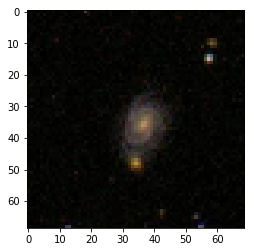

In [18]:
#random image to print
n=int(np.random.uniform(0,maxim,1))

if Y[n]==0:
    mor="elliptical"
else:
    mor="spiral"
print("Morphology: ", mor)    
plt.imshow(D[n,:,:,:].astype(int))

# Train

In [19]:
ntrain=int(D.shape[0]*8/10)
nval=int(ntrain/10)   


#I apply here some very simple normalization - you can change this too
mu = np.amax(D,axis=(1,2))


for i in range(0,mu.shape[0]):
    D[i,:,:,0] = D[i,:,:,0]/mu[i,0]
    D[i,:,:,1] = D[i,:,:,1]/mu[i,1]
    D[i,:,:,2] = D[i,:,:,2]/mu[i,2]

D, Y, = shuffle(D,Y,random_state=0)  #change order so that we do not use always the same objects to train/test


print("Training Model")
print("====================")
model_name=train_convnet_Nair(D,Y,ntrain,nval,model_name)

243.0
(50, 3)
255.0
(50, 3)
222.0
(50, 3)
226.0
(50, 3)
160.0
(50, 3)
190.0
(50, 3)
202.0
(50, 3)
237.0
(50, 3)
203.0
(50, 3)
192.0
(50, 3)
194.0
(50, 3)
247.0
(50, 3)
225.0
(50, 3)
255.0
(50, 3)
255.0
(50, 3)
246.0
(50, 3)
220.0
(50, 3)
158.0
(50, 3)
232.0
(50, 3)
214.0
(50, 3)
232.0
(50, 3)
234.0
(50, 3)
255.0
(50, 3)
255.0
(50, 3)
255.0
(50, 3)
238.0
(50, 3)
219.0
(50, 3)
255.0
(50, 3)
240.0
(50, 3)
247.0
(50, 3)
255.0
(50, 3)
244.0
(50, 3)
254.0
(50, 3)
209.0
(50, 3)
200.0
(50, 3)
225.0
(50, 3)
182.0
(50, 3)
218.0
(50, 3)
255.0
(50, 3)
164.0
(50, 3)
244.0
(50, 3)
255.0
(50, 3)
255.0
(50, 3)
255.0
(50, 3)
202.0
(50, 3)
208.0
(50, 3)
253.0
(50, 3)
216.0
(50, 3)
255.0
(50, 3)
246.0
(50, 3)
Training Model


/Users/marchuertascompany/anaconda3/envs/astrophd_tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (6, 6), input_shape=(69, 69, 3..., padding="same")`
  from ipykernel import kernelapp as app
/Users/marchuertascompany/anaconda3/envs/astrophd_tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same")`
/Users/marchuertascompany/anaconda3/envs/astrophd_tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same")`
/Users/marchuertascompany/anaconda3/envs/astrophd_tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (2, 2), padding="same")`
/Users/marchuertascompany/anaconda3/envs/astrophd_tutorial/lib/python3.6/site-packages/ipykerne

Compilation...
... done!
Model Summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 69, 69, 32)        3488      
_________________________________________________________________
activation_6 (Activation)    (None, 69, 69, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 69, 69, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 69, 69, 64)        51264     
_________________________________________________________________
activation_7 (Activation)    (None, 69, 69, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 34, 34, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 3

/Users/marchuertascompany/anaconda3/envs/astrophd_tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:72: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/Users/marchuertascompany/anaconda3/envs/astrophd_tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:72: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., steps_per_epoch=1, epochs=50)`


Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.6934 - acc: 0.5000 - val_loss: 0.6864 - val_acc: 0.6667
Epoch 2/50
1/1 [==============================] - 1s 1s/step - loss: 0.6885 - acc: 0.5000 - val_loss: 0.6787 - val_acc: 0.6667
Epoch 3/50
1/1 [==============================] - 2s 2s/step - loss: 0.6338 - acc: 0.6000 - val_loss: 0.6668 - val_acc: 0.6667
Epoch 4/50
1/1 [==============================] - 5s 5s/step - loss: 0.6890 - acc: 0.5333 - val_loss: 0.6689 - val_acc: 0.6667
Epoch 5/50


KeyboardInterrupt: 

# Classify test set

In [36]:
npred=D.shape[0]-(ntrain+nval)  #test sample size; 
pred_index=ntrain+nval          #test sample start index ;


print("Validating model")
print("====================")
Y_pred=test_convnet_Nair(D[pred_index:pred_index+npred,:,:,:],model_name) 
Y_test=Y[pred_index:pred_index+npred]   

6
Validating model
Loading weights /Users/marchuertascompany/Documents/teaching/IAC_WINTER/tutorials/Sab/Nair_ES.hd5
Compilation...
... done!
Model Summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 69, 69, 32)        3488      
_________________________________________________________________
activation_31 (Activation)   (None, 69, 69, 32)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 69, 69, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 69, 69, 64)        51264     
_________________________________________________________________
activation_32 (Activation)   (None, 69, 69, 64)        0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 34, 34, 64)     

/Users/marchuertascompany/anaconda3/envs/astrophd_tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (6, 6), input_shape=(69, 69, 3..., padding="same")`
  from ipykernel import kernelapp as app
/Users/marchuertascompany/anaconda3/envs/astrophd_tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same")`
/Users/marchuertascompany/anaconda3/envs/astrophd_tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same")`
/Users/marchuertascompany/anaconda3/envs/astrophd_tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (2, 2), padding="same")`
/Users/marchuertascompany/anaconda3/envs/astrophd_tutorial/lib/python3.6/site-packages/ipykerne

# Plot some accuracy plots

Global Accuracy: 0.666666666667


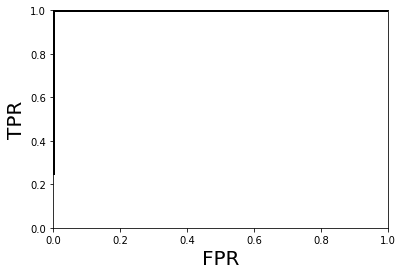

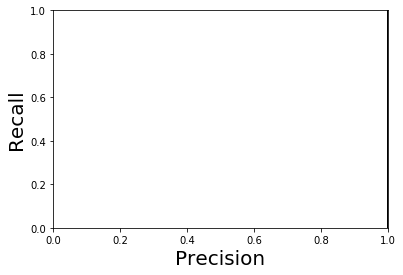

In [22]:
#global accuracy

Y_pred_class=Y_pred*0
Y_pred_class[Y_pred>0.5]=1
print("Global Accuracy:", accuracy_score(Y_test, Y_pred_class))

# ROC curve (False positive rate vs. True positive rate)
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)

#plot ROC
plt.xlabel("FPR", fontsize=20)
plt.ylabel("TPR", fontsize=20)
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot(fpr,tpr,linewidth=3,color='black')
plt.show()


# ROC curve (False positive rate vs. True positive rate)
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)

#plot ROC
plt.xlabel("Precision", fontsize=20)
plt.ylabel("Recall", fontsize=20)
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot(precision,recall,linewidth=3,color='black')
plt.show()

# Visualize images bad classifed

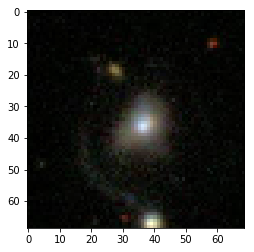

In [38]:
# objects classifed as early-types by the CNN but visually classifed as late-types
bad = np.where((Y_pred[:,0]<0.5)&(Y_test==1))

# objects classifed as late-types by the CNN but visually classifed as early-types
bad2 = np.where((Y_pred[:,0]>0.5)&(Y_test==0))


# show random image
n=int(np.random.uniform(0,bad2[0].shape,1))

plt.imshow(D[pred_index+bad2[0][0],:,:,:])
